In [3]:
import numpy as np

In [4]:
import ROOT
from array import array
from ROOT import TFile, TCanvas, TTree, TH1D, TH2D, gROOT, AddressOf, addressof, TGraph
from ROOT import TGraphErrors, TF1
from ROOT import TTreeReader, TTreeReaderArray
#defining the data structure of the file
ROOT.gInterpreter.Declare("""
struct slimport_data_t {\
    ULong64_t timetag;\
    UInt_t baseline;\
    UShort_t qshort;\
    UShort_t qlong;\
    UShort_t pur;\
    UShort_t scope[4096];\
};
""")
from ROOT import slimport_data_t

Welcome to JupyROOT 6.20/06


In [5]:
def GetSumHisto(branch='qlong', nbins=4000, xmin=0, xmax=20000):
    struct = slimport_data_t()
    tree = file.Get("acq_tree_0")
    branchA = tree.GetBranch("acq_ch0")
    branchB = tree.GetBranch("acq_ch1")
    branchC = tree.GetBranch("acq_ch2")
    branchA.SetAddress(AddressOf(struct, 'timetag'))
    tot_histo = TH1D("spectrum", "spectrum", nbins, xmin, xmax)

    for i in range(branchA.GetEntries()):
        CountA=branchA.GetEntry(i)
        CountB=branchB.GetEntry(i)
        CountC=branchC.GetEntry(i)
        if CountA>0:
            print(CountA)
        tot_histo.Fill(CountA+CountB+CountC)

    return tot_histo; 

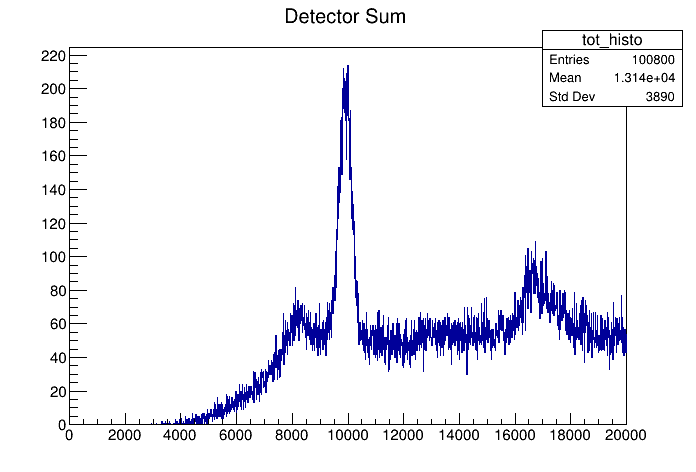

In [57]:
file = TFile("allegati/3fotoni20oremulti10range50ns.root")
struct0 = slimport_data_t()
struct1 = slimport_data_t()
struct2 = slimport_data_t()
tree = file.Get("acq_tree_0")
branch0 = tree.GetBranch("acq_ch0")
branch0.SetAddress(AddressOf(struct0, 'timetag'))
branch1= tree.GetBranch("acq_ch1")
branch1.SetAddress(AddressOf(struct1, 'timetag'))
branch2 = tree.GetBranch("acq_ch2")
branch2.SetAddress(AddressOf(struct2, 'timetag'))
tot_histo = TH1D('tot_histo', 'Detector Sum', 2000, 0, 20000)

for i in range(branch0.GetEntries()):
    branch0.GetEntry(i)
    branch1.GetEntry(i)
    branch2.GetEntry(i)
    tot_histo.Fill(struct0.qlong+struct1.qlong+struct2.qlong)


Ct = TCanvas()
tot_histo.Draw()
Ct.Draw()

20

In [5]:
def GetHisto(channel=0, branch='qlong', nbins=4000, xmin=0, xmax=20000):
    struct = slimport_data_t()
    tree = file.Get("acq_tree_0")
    branch = tree.GetBranch("acq_ch"+str(channel))
    branch.SetAddress(AddressOf(struct, 'timetag'))
    histo = TH1D("spectrum", "spectrum", nbins, xmin, xmax)

    for i in range(branch.GetEntries()):
        branch.GetEntry(i)
        histo.Fill(struct.qlong)

    return histo; 


def Get2DHisto(channel1=0, channel2=1, branch1='qlong', branch2='qlong'):
    struct1 = slimport_data_t()
    struct2 = slimport_data_t()

    branch1 = tree.GetBranch("acq_ch"+str(channel1))
    branch2 = tree.GetBranch("acq_ch"+str(channel2))
    
    branch1.SetAddress(AddressOf(struct1, 'timetag'))
    branch2.SetAddress(AddressOf(struct2, 'timetag'))

    
    histo = TH2D("2Dspectrum", "2Dspectrum", 1000, 0, 1000, 1000, 0, 1000)

    
    nev1 = branch1.GetEntries()
    nev2 = branch2.GetEntries()
    it1 = 0
    it2 = 0
    
    while it1<nev1 and it2<nev2:
        branch1.GetEntry(it1)
        branch2.GetEntry(it2)
        #complete the program!!
        
    return histo

    
def GetSignal(channel=0, nsamples=4096, evNr=2):
    struct = slimport_data_t()
    branch = tree.GetBranch("acq_ch"+str(channel))
    branch.SetAddress(AddressOf(struct, 'timetag'))
    
    branch.GetEntry(evNr)
    #x=array('H', nsamples*[0])
    #y=array('H', nsamples*[0])
    graph = TGraph(nsamples)

    for i in range(nsamples):
        graph.SetPoint(i, i, struct.scope[i])
    
    return graph


In [6]:
def Find_calib_par(centroids, sigmas, energies, Title="Calibration"):
    c_cal = TCanvas("Calibration_canvas","Calibar graphs ")
    c_cal.SetGrid()
    m = 1.
    q = 0.
    
    GraphErr = TGraphErrors(len(centroids),centroids,energies,sigmas)
    
    #GraphErr.SetMarkerStyle(22)
    GraphErr.SetLineColor(2)
    XAxis=GraphErr.GetXaxis()
    XAxis.SetTitle("Bins [A.U]")
    XAxis.SetTitleSize(0.037)
    XAxis.CenterTitle()
    YAxis=GraphErr.GetYaxis()
    YAxis.SetTitle("Energy [keV]")
    YAxis.SetTitleSize(0.037)
    YAxis.CenterTitle()
    GraphErr.SetTitle(Title)

    fitfunc = TF1("calfitfun1","pol1",np.amin(centroids),np.amax(centroids))
    fitfunc.SetParameters(0,0.1)
    
    GraphErr.Fit(fitfunc,"R")
    GraphErr.Draw()
    
    m = fitfunc.GetParameter(1)
    q = fitfunc.GetParameter(0)
    
    print("Slope = %f, Intercept = %f" %(m,q))
    
    c_cal.GraphErr = GraphErr
    c_cal.Draw()
    return m,q,c_cal

def CalibrateHisto(h_uncal, m, q):
    
    max_bin = h_uncal.GetNbinsX(); #This method returns the number of bins in x of the histogram
    max_kev = h_uncal.GetBinCenter(max_bin)*m + q
    XAxis = h_uncal.GetXaxis()
    XAxis.SetLimits(q,max_kev)
    if (m!=1 and q!=0): #This means that I actually changed the calibration!
        h_uncal.SetXTitle("keV")
    Cal_histo = h_uncal.Clone();
    
    return Cal_histo;


def subtract_bg(Histo, Histo_time, BG, BG_time):
    
    h_subtr = Histo.Clone()
    h_subtr.Add(BG,-Histo_time/BG_time)
    
    return h_subtr;




def peaksearch(Histo, xmin, xmax, ratio):
    
    h_peaks = Histo.Clone()
    XAxis = h_peaks.GetXaxis()
    XAxis.SetRangeUser(xmin, xmax)
    
    Histo.SetTitle("Measured spectrum")
    h_peaks.SetTitle("Peak search")
    
    s = ROOT.TSpectrum(30)
    
    Sigma =10
    
    nPeaks = s.Search(h_peaks,Sigma,"",ratio)
    xPeaks = s.GetPositionX()
    
    buffer=[]
    for p in range(nPeaks):
        print("Peak #%d @ channel %f" %(p,xPeaks[p]))
        buffer = np.append(buffer,xPeaks[p])
    xPeaks=buffer  
        
    return nPeaks, xPeaks


def Sub_BKG(Histo, SubComp, Binning , nI):
    nbins=Histo.GetNbinsX()
    xmin=0
    xmax=30000
    gROOT.ForceStyle()
    
    d1= TH1D("d1","", nbins, xmin, xmax)
    
    Histo.SetTitle("Estimation of background with Compton edges under peaks");
    #XAxis=Histo.GetXaxis()
    #XAxis.SetRange(1,nbins)
    Histo.Draw("L")
    
    s = ROOT.TSpectrum()
    source = np.empty(nbins)
    if SubComp==True:
        for i in range(nbins):
            source[i] = Histo.GetBinContent(i + 1)
        s.Background(source,nbins,nI,1,3,True,3,True)
    else:
        for i in range(nbins):
            source[i] = Histo.GetBinContent(i + 1)
        s.Background(source,nbins,nI,1,3,True,3,True)
        
    for i in range(nbins):
        d1.SetBinContent(i + 1,source[i])
        
    h_subtr = Histo.Clone()
    h_subtr.Add(d1,-1)
    
    return h_subtr

In [7]:
def Auto_calibration_Na22(Histo):
    H_Subtr=Sub_BKG(Histo,True,10,120)
    nPeaks,xPeaks = peaksearch(H_Subtr,1000,20000,0.1)
    
    Gf=[]
    Gpar=[]
    Function = ""
    for i in range(nPeaks):
        g = TF1("g%d"%i, "gaus", xPeaks[i]-150, xPeaks[i]+150)
        Gf.append(g)
        if i==0:
            H_Subtr.Fit(Gf[i],"QNR")
            Function = Function + ("gaus(%d)"%(i*3))
        else:
            H_Subtr.Fit(Gf[i],"QNR+")
            Function = Function + ("+gaus(%d)"%(i*3))
        Par=Gf[i].GetParameters()
        for k in range(3):
            Gpar = np.append(Gpar,Par[k])
            
    F_tot = TF1("F_tot",Function,0,30000)
    F_tot.SetParameters(Gpar)
    H_Subtr.Fit(F_tot,"QR+")
    Gpar = F_tot.GetParameters()
    
    Centroids = np.array([Gpar[1],Gpar[4]])
    Sigma = np.array([Gpar[2],Gpar[5]])
    Energies = np.array([511.,1274.5])
    
    m,q,calic_canvas = Find_calib_par(Centroids,Sigma,Energies)
    
    return m,q
    

In [8]:
i=1
print("Detector %d"%i)
i+=1
C=TCanvas()
file = TFile("Dati_calib/detector1_calibrazione10min.root")
Histo0=GetHisto(1, 'qlong', 3000, 0, 30000)
m0,q0=Auto_calibration_Na22(Histo0)
print("Detector %d"%i)
i+=1
file = TFile("Dati_calib/detector2_calibrazione10min.root")
Histo1=GetHisto(1, 'qlong', 3000, 0, 30000)
m1,q1=Auto_calibration_Na22(Histo1)
print("Detector %d"%i)
i+=1
file = TFile("Dati_calib/detector3_calibrazione10min.root")
Histo2=GetHisto(1, 'qlong', 3000, 0, 30000)
m2,q2=Auto_calibration_Na22(Histo2)
print("Detector %d"%i)
i+=1
file = TFile("Dati_calib/detector4_calibrazione_5min.root")
Histo3=GetHisto(1, 'qlong', 3000, 0, 30000)
m3,q3=Auto_calibration_Na22(Histo3)

Canvas = TCanvas()
Histo0.Draw()
Canvas.Draw()

Detector 1
Peak #0 @ channel 4885.000000
Peak #1 @ channel 11855.000000
Slope = 0.109321, Intercept = -22.217820
Detector 2
Peak #0 @ channel 4685.000000
Peak #1 @ channel 11355.000000
Slope = 0.114449, Intercept = -23.565128
Detector 3
Peak #0 @ channel 5135.000000
Peak #1 @ channel 12445.000000
Slope = 0.104643, Intercept = -25.869384
Detector 4
Peak #0 @ channel 3195.000000
Peak #1 @ channel 7755.000000
Slope = 0.167686, Intercept = -23.556055


AttributeError: 'PyROOT_NoneType' object has no attribute 'Draw'

 FCN=4.22612e-12 FROM MIGRAD    STATUS=CONVERGED      52 CALLS          53 TOTAL
                     EDM=8.44656e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -2.22178e+01   3.53868e+01   7.19734e-03  -6.71729e-09
   2  p1           1.09321e-01   4.78095e-03   9.72439e-07   8.14238e-04
 FCN=1.28579e-09 FROM MIGRAD    STATUS=CONVERGED      52 CALLS          53 TOTAL
                     EDM=2.57092e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -2.35651e+01   3.49881e+01   7.10355e-03   7.45251e-07
   2  p1           1.14449e-01   4.95011e-03   1.00516e-06   1.91099e-02
 FCN=1.72487e-07 FROM MIGRAD    STATUS=CONVERGED      39 CALLS          40 TOTAL
                 

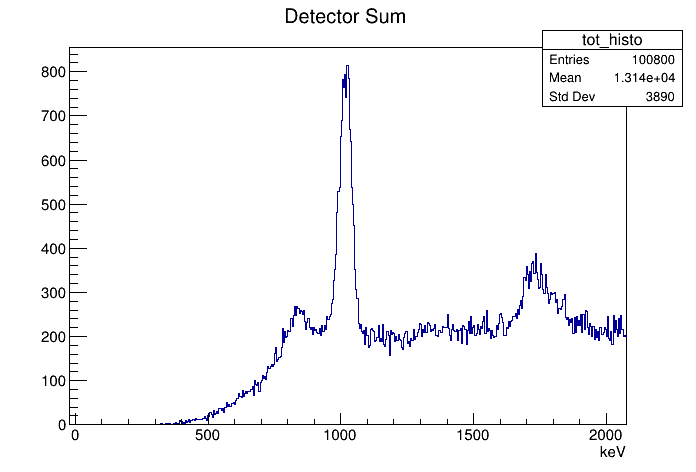

In [15]:
file = TFile("allegati/3fotoni20oremulti10range50ns.root")
struct0 = slimport_data_t()
struct1 = slimport_data_t()
struct2 = slimport_data_t()
tree = file.Get("acq_tree_0")
branch0 = tree.GetBranch("acq_ch0")
branch0.SetAddress(AddressOf(struct0, 'timetag'))
branch1= tree.GetBranch("acq_ch1")
branch1.SetAddress(AddressOf(struct1, 'timetag'))
branch2 = tree.GetBranch("acq_ch2")
branch2.SetAddress(AddressOf(struct2, 'timetag'))
tot_histo = TH1D('tot_histo', 'Detector Sum', 500, 0, 20000)

for i in range(branch0.GetEntries()):
    branch0.GetEntry(i)
    branch1.GetEntry(i)
    branch2.GetEntry(i)
    tot_histo.Fill(struct0.qlong+struct1.qlong+struct2.qlong)
    
tot_histo=CalibrateHisto(tot_histo,0.105,-22)


Ct = TCanvas()
tot_histo.Draw()
Ct.Draw()